In [ ]:
!pip install Transformers

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import os
import csv
import nltk
import spacy
import json

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [ ]:
from tensorflow.keras.layers import Input,GlobalMaxPool1D,BatchNormalization,Dense,Dropout
from tensorflow.keras import Model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

In [ ]:
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import load_model

In [ ]:
tf.executing_eagerly()

True

In [ ]:
from transformers import AutoTokenizer, TFAutoModel

In [ ]:
from google.colab import drive
drive._mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
corpora = '/content/gdrive/MyDrive/Colab Data/articles'
tagged_data=[]
irrelevant_docs=0
irrelevant_docs_address=[]
df_corpus={'Content':[],'Label':[]}

for subdir, dirs, files in os.walk(corpora):
  for file in files:
    #print(data_file)
    path = os.path.join(subdir, file)
    #print(path)
    """print(tagged_file_content(json.load(open(path))),'\n\n')
    del path"""
    
    with open(path,'r') as f:
      data=json.load(f)
      if data['candidateLabels']: #not an empty list thus relevant document
        #tagged_data.append(tagged_file_content(data))

        if data['content']:
          df_corpus['Content'].append(data['content'].replace('\r', '').replace('\t', '').replace('\n','').replace('&#13;',''))
          df_corpus['Label'].append('relevant')
        #else:
          #print(path,'\n')

      else:#irrelevant document
        """df_corpus['Content'].append(data['content'])
        df_corpus['Label'].append('irrelevant')"""

        if data['content']:
          df_corpus['Content'].append(data['content'].replace('\r', '').replace('\t', '').replace('\n','').replace('&#13;',''))
          df_corpus['Label'].append('irrelevant')
        #else:
          #print(path,'\n')#some irrelevant articles have no content
        
        #irrelevant_docs=irrelevant_docs+1
        #irrelevant_docs_address.append(path)
        #break

#print("Irrelevant Docs are: ",irrelevant_docs)

In [ ]:
data=pd.DataFrame(df_corpus)

In [ ]:
label_encoder=LabelEncoder()
label_encoder.fit(data['Label'])

LabelEncoder()

In [ ]:
data['Label']=list(label_encoder.transform(data['Label']))

In [ ]:
int(np.round(len(data)*0.6))

302

In [ ]:
df_train=data.iloc[0:int(np.round(len(data)*0.6))]
df_test=data.iloc[int(np.round(len(data)*0.6)):]

In [ ]:
len(df_train)

302

In [ ]:
len(df_test)

201

In [ ]:
df_train.head()

,Content,Label
0,Instead of creating unnecessary fear and paran...,0
1,The International Monetary Fund has given Bot...,0
2,10 October 2015 Last updated at: 5:05 AM M...,0
3,YAMAGUCHI – An outbreak of highly pathogenic ...,1
4,SEOUL South Korea has confirmed a fresh case o...,1


In [ ]:
tokenizer=AutoTokenizer.from_pretrained('distilbert-base-cased')

In [ ]:
bert=TFAutoModel.from_pretrained('distilbert-base-cased')

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
def tokenize(sentence):
  tokens=tokenizer.encode_plus(sentence,max_length=SEQ_LEN,
                               truncation=True,
                               padding='max_length',add_special_tokens=True,
                               return_attention_mask=True,return_token_type_ids=False,return_tensors='tf')
  return tokens['input_ids'],tokens['attention_mask']

In [ ]:
np.unique(df_train['Label'].values)

array([0, 1])

In [ ]:
arr=df_train['Label'].values
labels=np.zeros((arr.size,arr.max()+1))
labels[np.arange(arr.size),arr]=1

In [ ]:
SEQ_LEN=128
BATCH_SIZE=16
epochs=50

In [ ]:
Xids=np.zeros((len(df_train),SEQ_LEN))
Xmask=np.zeros((len(df_train),SEQ_LEN))

In [ ]:
#df_1=df_train.dropna()
for i,sentence in enumerate(df_train['Content']):
  Xids[i, :],Xmask[i, :]=tokenize(sentence)

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((Xids,Xmask,labels))

In [ ]:
def map_func(input_ids,masks,labels):
  return {'input_ids':input_ids,'attention_mask':masks},labels

In [ ]:
dataset=dataset.map(map_func)

In [ ]:
for x,y in enumerate(dataset):
  print(y)
  break

({'input_ids': <tf.Tensor: shape=(128,), dtype=float64, numpy=
array([  101.,  3743.,  1104.,  3780., 14924.,  2945.,  1105., 18311.,
        2728.,  1465.,  1166.,   187., 23156.,  1279.,   117.,  1103.,
        3912.,  1431.,  4609.,  4778.,  1972.,  1113.,  1103.,  3653.,
        1177., 11887.,  1116.,  1169.,  1618.,  3244.,  2310.,  1105.,
        1147., 23463.,   119., 18732., 25290., 11680.,  1942.,  2064.,
        1183.,  8430., 24641.,  7088.,  1103.,  2793.,  8679.,  1104.,
         170.,   187., 23156.,  1279.,  8010.,  1107.,  5355.,   117.,
        1175.,  5903.,  1242.,  1940., 11428.,  3633., 18225.,  1116.,
        1164.,  1103.,  3653.,  1105.,  1293.,  3843.,  1895.,  1105.,
        7299.,  1895.,  1122.,  1110.,   119.,  1398.,  4064.,  1143.,
        1106.,  4267., 20080.,  1883.,  1199.,  1104.,  1292., 21557.,
        1114., 15780.,  3509.,   119.,  1422.,  1582.,   122.,   131.,
       15859.,  1150.,  3370., 21381.,  1118.,   170.,   187., 23156.,
        1181.,

In [ ]:
#dataset=dataset.shuffle(10000).batch(512)

In [ ]:
DS_LEN=len(list(dataset))

In [ ]:
DS_LEN

302

In [ ]:
SPLIT=0.6
train=dataset.take(round(DS_LEN*SPLIT))
val=dataset.skip(round(DS_LEN*SPLIT))

In [ ]:
len(val)

121

In [ ]:
input_ids=Input(shape=(SEQ_LEN,),name="input_ids",dtype='int32')
mask=Input(shape=(SEQ_LEN,),name='attention_mask',dtype='int32')
embeddings=bert(input_ids,attention_mask=mask)[0]
X=GlobalMaxPool1D()(embeddings)
X=BatchNormalization()(X)
X=Dense(64,activation='relu')(X)
X=Dropout(0.2)(X)
y=Dense(2,activation='softmax',name='outputs')(X)

In [ ]:
model=Model(inputs=[input_ids,mask],outputs=y)
model.layers[2].trainable=False

In [ ]:
#model.summary()

In [ ]:
#optimizer=Adam(0.01)
loss=CategoricalCrossentropy()
accuracy=CategoricalAccuracy('accuracy')

In [ ]:
!pip install -q tf-models-official

In [ ]:
from official.nlp import optimization

In [ ]:
#epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
num_train_steps = steps_per_epoch * epochs
#num_warmup_steps = int(0.1*num_train_steps)
num_warmup_steps = 0 #mine

init_lr = 1e-5
eps=1e-8
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [ ]:
model.compile(optimizer=optimizer,loss=loss,metrics=['acc'])

In [ ]:
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc=ModelCheckpoint('best_model.h5',monitor='val_acc',mode='max',save_weights_only=True,verbose=1)

In [ ]:
#train

In [ ]:
history=model.fit(train.shuffle(1000).batch(BATCH_SIZE),epochs=epochs,validation_data=val.batch(BATCH_SIZE),verbose=1,validation_steps=1)

Epoch 1/50
12/12 [==============================] - 20s 524ms/step - loss: 0.8867 - acc: 0.6022 - val_loss: 0.6962 - val_acc: 0.7500
Epoch 2/50
12/12 [==============================] - 2s 183ms/step - loss: 0.9342 - acc: 0.5801 - val_loss: 0.6557 - val_acc: 0.7500
Epoch 3/50
12/12 [==============================] - 2s 187ms/step - loss: 0.8085 - acc: 0.6243 - val_loss: 0.6265 - val_acc: 0.7500
Epoch 4/50
12/12 [==============================] - 2s 190ms/step - loss: 0.7876 - acc: 0.6133 - val_loss: 0.6007 - val_acc: 0.7500
Epoch 5/50
12/12 [==============================] - 2s 183ms/step - loss: 0.8774 - acc: 0.5635 - val_loss: 0.5775 - val_acc: 0.7500
Epoch 6/50
12/12 [==============================] - 2s 184ms/step - loss: 0.8245 - acc: 0.6022 - val_loss: 0.5592 - val_acc: 0.7500
Epoch 7/50
12/12 [==============================] - 2s 183ms/step - loss: 0.7760 - acc: 0.5691 - val_loss: 0.5469 - val_acc: 0.7500
Epoch 8/50
12/12 [==============================] - 2s 187ms/step - loss: 0

In [ ]:
#history.history

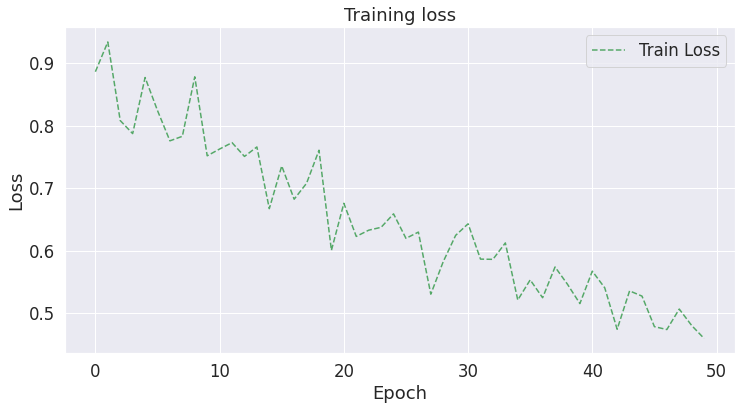

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# learning curve
#plt.plot(loss_values, 'b-o')
plt.plot(history.history['loss'],'g--',label='Train Loss')
#plt.plot(history.history['val_acc'],'b',label='Val Accuracy')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
print(history.history['loss'])

[0.8866538405418396, 0.9342406988143921, 0.8084975481033325, 0.7875945568084717, 0.8773744702339172, 0.8245067000389099, 0.7760425209999084, 0.7833065390586853, 0.8784903883934021, 0.7521083950996399, 0.7629628777503967, 0.7731646299362183, 0.7511080503463745, 0.7662729620933533, 0.6675549745559692, 0.7358502149581909, 0.6826362609863281, 0.7081995010375977, 0.7610237002372742, 0.600818395614624, 0.6761114001274109, 0.6231296062469482, 0.6330937743186951, 0.6377111673355103, 0.6592248678207397, 0.6200371980667114, 0.6300418972969055, 0.530722975730896, 0.582728385925293, 0.6248407363891602, 0.6432936191558838, 0.5868114233016968, 0.5864548087120056, 0.6127276420593262, 0.5213626623153687, 0.5535983443260193, 0.5250251889228821, 0.5742321610450745, 0.5466144680976868, 0.5156949162483215, 0.5675602555274963, 0.5409212708473206, 0.47458329796791077, 0.5359850525856018, 0.5276238322257996, 0.47876545786857605, 0.4741424322128296, 0.5069094300270081, 0.480573445558548, 0.4598500430583954]


In [ ]:
#_,val_acc=model.evaluate(test_dataset)

In [ ]:
Tids=np.zeros((len(df_test),SEQ_LEN))
Tmask=np.zeros((len(df_test),SEQ_LEN))

In [ ]:
for i,sentence in enumerate(df_test['Content']):
  Tids[i, :],Tmask[i, :]=tokenize(sentence)

In [ ]:
arra=df_test['Label'].values
test_labels=np.zeros((arra.size,arra.max()+1))
test_labels[np.arange(arra.size),arra]=1

In [ ]:
test_dataset=tf.data.Dataset.from_tensor_slices((Tids,Tmask,test_labels))

In [ ]:
test_dataset=test_dataset.map(map_func)

In [ ]:
_,val_acc=model.evaluate(test_dataset.batch(BATCH_SIZE))

13/13 [==============================] - 2s 147ms/step - loss: 0.5299 - acc: 0.7463


In [ ]:
val_acc

0.746268630027771